# Import Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay
from mlflow.sklearn import autolog

C:\Users\rikes\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load the Data

In [2]:
# read the csv file

df = pd.read_csv("data/titanic.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# check for missing values in data

(
    df
    .isna()
    .sum()
)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Observations:
1. `Age`, `Emabrked` and `Cabin` columns have missing values.

In [4]:
# info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data CLeaning

In [5]:
# columns to drop

columns_to_drop = ['passengerid','name','ticket','cabin']

In [6]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family = lambda df_ : df_['sibsp'] + df_['parch']
        )
        .drop(columns=['sibsp','parch'])
    )

In [7]:
final_df = clean_data(df)

final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [8]:
# shape of the cleaned data 

print(f'The cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The cleaned data has 891 rows and 7 columns


In [9]:
# missing values in the cleaned data

(
    final_df
    .isna()
    .sum()
)

survived      0
pclass        0
sex           0
age         177
fare          0
embarked      2
family        0
dtype: int64

# EDA

In [10]:
# distribution of target

(
    final_df
    .loc[:,'survived']
    .value_counts(normalize=True)
)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [11]:
# boxplots

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

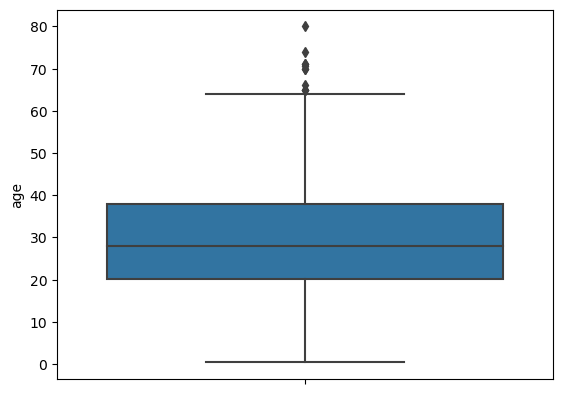

In [12]:
# boxplot for age column
create_boxplot(final_df,'age')

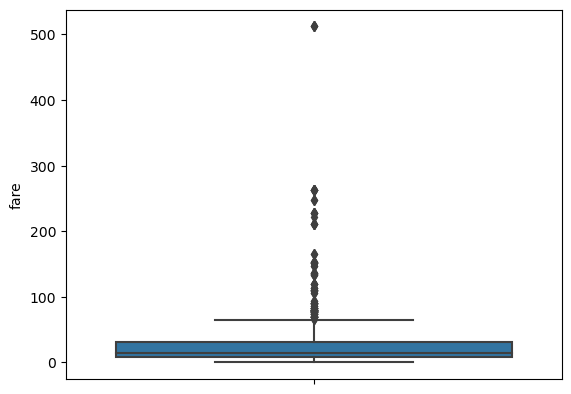

In [13]:
# boxplot for fare column

create_boxplot(final_df,'fare')

#### Overview

* Outliers in the age and fare columns

In [14]:
# plot the distribution of categorical columns

def plot_distribution(data,column_name):
    sns.countplot(data=data, x=column_name)

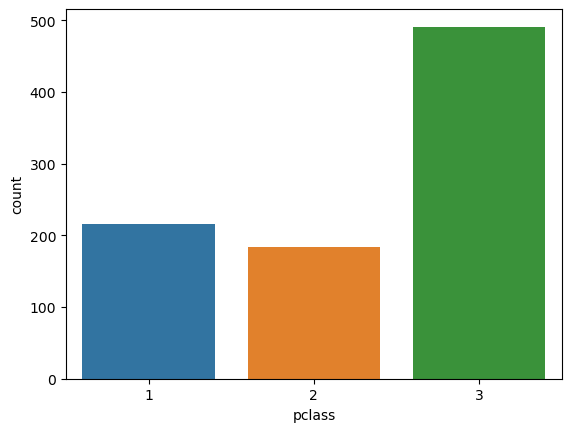

In [15]:
# distribution for pclass
plot_distribution(final_df,'pclass')

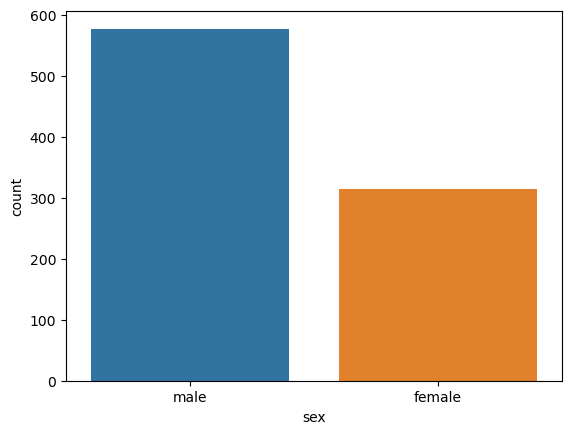

In [16]:
# distribution for sex

plot_distribution(final_df,'sex')

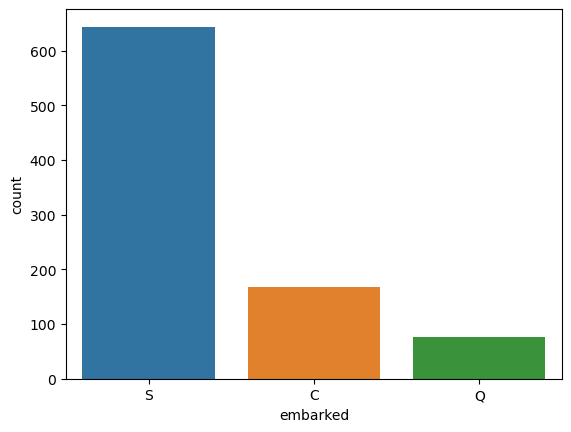

In [17]:
# distribution for embarked 

plot_distribution(final_df,'embarked')

# Feature_Eng

In [18]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [19]:
# make X and y

X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [20]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [21]:
# do train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print('The shape of training data is',X_train.shape)
print('The shape of testing data is',X_test.shape)

The shape of training data is (712, 6)
The shape of testing data is (179, 6)


# Pipelines for Individual Columns

In [22]:
# age_pipeline
age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('scale',StandardScaler())
])


age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [23]:
# fare pipeline

fare_pipe = Pipeline(steps=[
    ('scale',StandardScaler())
])

fare_pipe

Pipeline(steps=[('scale', StandardScaler())])

In [24]:
# embarked_pipeline

embarked_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('encode',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('encode',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Column Transformer

In [25]:
set_config(transform_output='pandas')

In [26]:
# make column column transformer

preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked',embarked_pipe,['embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['sex']),
    ('family',MinMaxScaler(),['family'])
],remainder='passthrough',n_jobs=-1,force_int_remainder_cols=False)

preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [27]:
# fit and transform the training data

preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked_C,embarked__embarked_Q,embarked__embarked_S,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.253641,-0.078684,0.0,0.0,1.0,0.0,1.0,0.0,1
733,-0.477284,-0.377145,0.0,0.0,1.0,0.0,1.0,0.0,2
382,0.215086,-0.474867,0.0,0.0,1.0,0.0,1.0,0.0,3
704,-0.246494,-0.476230,0.0,0.0,1.0,0.0,1.0,0.1,3
813,-1.785093,-0.025249,0.0,0.0,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...,...,...
106,-0.631144,-0.480162,0.0,0.0,1.0,1.0,0.0,0.0,3
270,-0.092634,-0.030545,0.0,0.0,1.0,0.0,1.0,0.0,1
860,0.907456,-0.355804,0.0,0.0,1.0,0.0,1.0,0.2,3
435,-1.169653,1.683201,0.0,0.0,1.0,1.0,0.0,0.3,1


In [28]:
preprocessor.get_params()

{'force_int_remainder_cols': False,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('scale', StandardScaler())]),
   ['age']),
  ('fare', Pipeline(steps=[('scale', StandardScaler())]), ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('encode',
                    OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('scale', StandardScaler())]),
 'fare': Pipeline(steps=[('scale', StandardScaler())]),
 'embarked': Pipeline(steps=[('impute', SimpleImputer(strategy=

# Model Pipeline

In [29]:
# build the model pipeline

model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [30]:
model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('clf',RandomForestClassifier())
])

model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf', RandomForestClassifier())])

# MLFlow Tracking code

## Grid Search

In [32]:
# set the uri for server

mlflow.set_tracking_uri("http://127.0.0.1:8000")

mlflow.set_experiment("Grid Search")

mlflow.sklearn.autolog()

params_grid = {
    "clf__n_estimators": list(range(100,400,100)),
    "clf__max_depth": [2,3,4,5,6,7]
}

with mlflow.start_run(run_name='outer',nested=True) as parent:
    # grid search object
    grid_search = GridSearchCV(estimator=model_pipe,
                               cv=3,
                               param_grid=params_grid,
                               scoring='accuracy',
                               n_jobs=-1)
    # fit the grid search
    grid_search.fit(X_train,y_train)

with mlflow.start_run(run_name='best_model') as best:
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("best_accuracy",grid_search.best_score_)
    mlflow.sklearn.log_model(sk_model=grid_search.best_estimator_,
                            artifact_path='best_model',
                            registered_model_name='Titanic_Random_Forest')

2024/12/19 09:36:03 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/12/19 09:36:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have mis

🏃 View run bright-mink-96 at: http://127.0.0.1:8000/#/experiments/258752146598027028/runs/7b1854587c694f468b1ae0aadb7ce799
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/258752146598027028
🏃 View run salty-hare-274 at: http://127.0.0.1:8000/#/experiments/258752146598027028/runs/bccb1fbeafa1455693f8133c7175e8b9
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/258752146598027028
🏃 View run upset-kit-489 at: http://127.0.0.1:8000/#/experiments/258752146598027028/runs/f2826ab07c7b44efad705c4cbeee66fb
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/258752146598027028
🏃 View run puzzled-goat-894 at: http://127.0.0.1:8000/#/experiments/258752146598027028/runs/1a120a33bc524ec187e8e87f5b08307e
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/258752146598027028
🏃 View run big-trout-663 at: http://127.0.0.1:8000/#/experiments/258752146598027028/runs/3a543c9c2b3f496fbdde3f03d15d6911
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/258752146598027028


2024/12/19 09:36:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Titanic_Random_Forest' already exists. Creating a new version of this model...
2024/12/19 09:36:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Titanic_Random_Forest, version 2
Created version '2' of model 'Titanic_Random_Forest'.


🏃 View run best_model at: http://127.0.0.1:8000/#/experiments/258752146598027028/runs/69b67eb03c594c49983706490e1df840
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/258752146598027028


# Hyperopt

In [33]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [34]:
# define the search space

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'criterion': hp.choice('criterion',['gini','entropy'])
}

In [35]:
def objective(params):
    with mlflow.start_run(nested=True):
        # log the params
        mlflow.log_params(params)
        n_estimators = int(params['n_estimators'])
        max_depth = int(params['max_depth'])
        # model object
        model_pipe.named_steps['clf'].set_params(**{'n_estimators':n_estimators,'max_depth':max_depth})
        # model fit
        model_pipe.fit(X_train,y_train)
        # calculate predictions
        y_pred = model_pipe.predict(X_test)
        # calculate accuracy
        accuracy = accuracy_score(y_test,y_pred)
        mlflow.log_metric("accuracy",accuracy)

    return {"loss":-accuracy,"status":STATUS_OK}

In [36]:
# set the tracking uri

mlflow.set_tracking_uri("http://127.0.0.1:8000")

mlflow.set_experiment("HP Tuning Hyperopt")

with mlflow.start_run(nested=True):
    # set the fmin function
    trials = Trials()
    
    best = fmin(fn=objective, 
                space=space, 
                algo=tpe.suggest, 
                max_evals=50, 
                trials=trials)

2024/12/19 10:10:02 INFO mlflow.tracking.fluent: Experiment with name 'HP Tuning Hyperopt' does not exist. Creating a new experiment.


  0%|                                                         | 0/50 [00:00<?, ?trial/s, best loss=?]

2024/12/19 10:10:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run carefree-mink-578 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/43ce5aa2d7a94dd4a6edac4c9b272d77

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

  2%|▌                             | 1/50 [00:08<06:48,  8.33s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run rare-shrimp-681 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/125fda6b22b14664843f81f9752669e3

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

  4%|█▏                            | 2/50 [00:12<04:52,  6.08s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run efficient-grub-171 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/dee9ab419d4b4c2e9b499cb83839e11d

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

  6%|█▊                            | 3/50 [00:17<04:10,  5.32s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run resilient-tern-387 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/d30f89802d374f4eb31d96d375a0b6f9

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

  8%|██▍                           | 4/50 [00:21<03:44,  4.88s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run learned-toad-752 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/9c307ee0efbc461e9b1c0943a860c851

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 10%|███                           | 5/50 [00:25<03:31,  4.70s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run capable-fowl-165 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/d286cbab0c0e467ea148a80cdf3fa99c

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 12%|███▌                          | 6/50 [00:30<03:21,  4.58s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run charming-koi-409 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/c8be8824ef2742d1bae2185f807836a1

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 14%|████▏                         | 7/50 [00:34<03:10,  4.44s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run zealous-roo-884 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/67a7771e113c474695c8bc04c15dbeb6

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 16%|████▊                         | 8/50 [00:38<03:04,  4.39s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run masked-squirrel-328 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/6b68275a181e4575935a64bb19619db4

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 18%|█████▍                        | 9/50 [00:42<02:58,  4.34s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run skillful-slug-963 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/6d8d376d491d4dad943888c29fd37212

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 20%|█████▊                       | 10/50 [00:47<02:55,  4.40s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run bemused-goose-842 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/6f057b6073d740478ca9d425989fb83a

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 22%|██████▍                      | 11/50 [00:51<02:48,  4.33s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run aged-fly-738 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/4cb1312d1c944d86897e28aad053eb69

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 24%|██████▉                      | 12/50 [00:55<02:42,  4.27s/trial, best loss: -0.8379888268156425]

2024/12/19 10:10:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:10:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run agreeable-toad-359 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/e29fc11ac6274944a2703e1c12ddc46d

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 26%|███████▌                     | 13/50 [00:59<02:37,  4.26s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run fortunate-colt-845 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/652823f5548a4265818aa15319706019

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 28%|████████                     | 14/50 [01:04<02:31,  4.22s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run puzzled-skunk-387 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/82491bca3f1e4582baebcecda817c55b

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 30%|████████▋                    | 15/50 [01:08<02:27,  4.20s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run merciful-goat-897 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/596aa083334f4649bb29cf9e3a1b3eed

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 32%|█████████▎                   | 16/50 [01:12<02:23,  4.22s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run peaceful-squid-393 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/013d14eb0dcc47a098f4f078436d6171

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 34%|█████████▊                   | 17/50 [01:16<02:15,  4.11s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run painted-whale-676 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/985d87b151724ac5923dcbacdaff3aff

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 36%|██████████▍                  | 18/50 [01:20<02:12,  4.14s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run gregarious-hen-33 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/79e669cd6bc1419a8d0291f493c8ad2e

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 38%|███████████                  | 19/50 [01:24<02:07,  4.12s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run enchanting-yak-987 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/fbe6ca381f364109ae71fc1d5789c6ce

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 40%|███████████▌                 | 20/50 [01:28<02:01,  4.05s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run intelligent-mink-739 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/5546deb1c4f64036b109e74f23be3e80

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 42%|████████████▏                | 21/50 [01:32<01:58,  4.09s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run treasured-skunk-50 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/550dc300e73e4bfabdf05ccd205cb8d6

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 44%|████████████▊                | 22/50 [01:36<01:55,  4.14s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run entertaining-kit-801 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/4fe4e5d29bae41559fa9aac9a6f4f34b

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 46%|█████████████▎               | 23/50 [01:40<01:49,  4.07s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run tasteful-lamb-113 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/424b392428a54d8e968434d764e68ec6

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 48%|█████████████▉               | 24/50 [01:44<01:44,  4.01s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run peaceful-tern-138 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/e8ee168f263b4e8583b6a7f8b1fcf12f

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 50%|██████████████▌              | 25/50 [01:49<01:42,  4.11s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run illustrious-crab-135 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/a1b63a58e6f348a19396b6ac52ec0bb1

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 52%|███████████████              | 26/50 [01:53<01:39,  4.15s/trial, best loss: -0.8379888268156425]

2024/12/19 10:11:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:11:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run hilarious-mare-596 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/17ed0067ae924f00abde442ff09ec1df

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 54%|███████████████▋             | 27/50 [01:57<01:36,  4.19s/trial, best loss: -0.8379888268156425]

2024/12/19 10:12:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run amazing-grub-666 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/8c6981a35f4843c6854f6369194d45f2

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 56%|████████████████▏            | 28/50 [02:01<01:32,  4.20s/trial, best loss: -0.8379888268156425]

2024/12/19 10:12:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run unequaled-roo-683 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/9e455af1f5d3418983f02c775e252f2d

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 58%|████████████████▊            | 29/50 [02:06<01:29,  4.26s/trial, best loss: -0.8379888268156425]

2024/12/19 10:12:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run zealous-auk-747 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/c2990022dfe44f34b20f9d47a9526972

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 60%|█████████████████▍           | 30/50 [02:10<01:24,  4.24s/trial, best loss: -0.8379888268156425]

2024/12/19 10:12:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run burly-stoat-836 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/67e72ef3294b47199ce0f606804b0124

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 62%|█████████████████▉           | 31/50 [02:15<01:22,  4.36s/trial, best loss: -0.8379888268156425]

2024/12/19 10:12:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run capricious-panda-908 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/64b5f41dcaf647c0bab075b23f1fbd72

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 64%|██████████████████▌          | 32/50 [02:19<01:19,  4.40s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run enthused-stork-577 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/68b44f50648644bfb66124ef899adf57

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 66%|███████████████████▏         | 33/50 [02:23<01:14,  4.37s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run suave-donkey-782 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/d04a127d32434a8ca963b62729e53b58

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 68%|███████████████████▋         | 34/50 [02:28<01:09,  4.35s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run thoughtful-dog-838 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/420a590f99054231a6971763aa43ddba

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 70%|████████████████████▎        | 35/50 [02:32<01:05,  4.34s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run wistful-shark-826 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/8ac4068b689340e687acfe41bb9f78dd

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 72%|████████████████████▉        | 36/50 [02:36<01:01,  4.37s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run incongruous-foal-528 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/0ffdfae62c6d410198dfbd05db1e0d1f

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 74%|█████████████████████▍       | 37/50 [02:41<00:57,  4.43s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run crawling-finch-393 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/3e013ebeada346a38f5d71a4e20c3c26

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 76%|██████████████████████       | 38/50 [02:45<00:53,  4.46s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run capricious-hare-106 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/53501b0a324640078608a1cbcca7f7fb

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 78%|██████████████████████▌      | 39/50 [02:50<00:49,  4.47s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run rumbling-dove-739 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/b6d09fe755d94c649a1d30353c5b71f2

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 80%|███████████████████████▏     | 40/50 [02:54<00:43,  4.39s/trial, best loss: -0.8435754189944135]

2024/12/19 10:12:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:12:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run marvelous-fox-245 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/4c40ff1d23524ebe8a1a8fffb4546d85

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 82%|███████████████████████▊     | 41/50 [02:58<00:39,  4.34s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run sneaky-flea-52 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/8f33cfad4d894ea8b8c0a2bfea753677

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 84%|████████████████████████▎    | 42/50 [03:03<00:34,  4.33s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run clumsy-gnu-291 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/5a68d38264dc48218a19644b21ccdaad

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 86%|████████████████████████▉    | 43/50 [03:07<00:30,  4.30s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run calm-ape-108 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/5ca2bfed85db44c39226be0249d474e7

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 88%|█████████████████████████▌   | 44/50 [03:11<00:26,  4.34s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run carefree-mole-23 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/745d1720118a4c8489cbab60113ce7af

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 90%|██████████████████████████   | 45/50 [03:16<00:21,  4.38s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run merciful-dolphin-215 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/b6c2eadd50c14d229c81dd343653253a

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 92%|██████████████████████████▋  | 46/50 [03:21<00:18,  4.53s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run learned-lynx-42 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/b4a1089229d64289b3bc857a7c3808be

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 94%|███████████████████████████▎ | 47/50 [03:25<00:13,  4.44s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run masked-pug-867 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/98b23325b9e042309558dd1a883be1d5

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 96%|███████████████████████████▊ | 48/50 [03:29<00:08,  4.36s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run beautiful-chimp-512 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/e417ae9fd7f54cb28a15a458bf023a01

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

 98%|████████████████████████████▍| 49/50 [03:33<00:04,  4.34s/trial, best loss: -0.8435754189944135]

2024/12/19 10:13:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/12/19 10:13:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\rikes\anaconda3\Lib\site-packages\mlflow\type

🏃 View run crawling-mink-558 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/441b56dbcb8c409d90e6e25636a8b6da

🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930                        

100%|█████████████████████████████| 50/50 [03:38<00:00,  4.37s/trial, best loss: -0.8435754189944135]
🏃 View run adaptable-pug-547 at: http://127.0.0.1:8000/#/experiments/491389092300289930/runs/7c9b87e664b54e258360524101055ee3
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/491389092300289930
